# Determining the prospective tariff for a telecom company

You are an analyst at Megaline, a federal mobile operator. Customers are offered two tariff plans: "Smart" and "Ultra". To adjust the advertising budget, the commercial department wants to understand which tariff brings in more money.
You will have to make a preliminary analysis of the tariffs on a small sample of customers. You have at your disposal the data of 500 users of Megalain»: who they are, where they come from, what tariff they use, how many calls and messages each sent in 2018. You need to analyze the behavior of customers and make a conclusion — which tariff is better.

## План работы

* [Этап 1. Открытие файлов и их прочтение.](#1-bullet)
* [Этап 2. Предобработка данных.](#2-bullet)
* [Этап 3. Анализ данных.](#3-bullet)
* [Этап 4. Проверка гипотез.](#4-bullet)
* [Этап 5. Общий вывод.](#5-bullet)

## Этап 1. Открытие файлов и их прочтение.

In [1]:
from scipy import stats as st
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

Импортируем библиотеки, которые в дальнейшем нам понадобятся.

Прочитаем все файлы, всего их пять.

In [2]:
calls = pd.read_csv('/datasets/calls.csv') 
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [5]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [6]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [7]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Все таблицы прочлись правильно, а потому можем переходить к следующему шагу.

## Этап 2. Предобработка данных.

Теперь посмотрим на информацию о каждом из датасетов.

In [8]:
df = [calls, internet, messages, tariffs, users]

In [9]:
for i in df:
   
    i.info()
    print()
    print('-------------------------')
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

-------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

-------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory u

Что бросается в глаза: нужно заменить во всех таблицах формат даты. После чего, как указано в методичке, нужно будет округлить количество минут и мегабайтов в большую сторону, в соответсвии с политикой компании.

In [10]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

Для начала посмотрим, какую долю составляют звонки продолжительность 0 секунд

In [11]:
'Доля звонков с нулевой продолжительностью = ', round((calls.loc[calls['duration']==0, 'duration'].count() / len(calls)) * 100)

('Доля звонков с нулевой продолжительностью = ', 20)

20% доля - это много, посмотрим, есть ли какая-то специфическая причина

Можем проследить, были ли какие-то сбои в определнные месяцы, так как отдельные дни проверять сложно, а года нам также не подходя, в выборке он один.

In [12]:
calls['month'] = calls['call_date'].dt.month

In [13]:
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


In [14]:
calls_date_0 = calls.loc[calls['duration'] == 0]

In [15]:
calls_date_0.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
5,1000_5,2018-11-02,0.0,1000,11
6,1000_6,2018-10-18,0.0,1000,10
9,1000_9,2018-08-15,0.0,1000,8


In [16]:
calls_date = calls_date_0.pivot_table(index='month', values = 'duration', aggfunc='count')

In [17]:
calls_date.columns = ['count_0']

In [18]:
calls_date

,count_0
month,
1,312
2,623
3,1304
4,1768
5,2531
6,2883
7,3518
8,4231
9,4615


Добавим общее количество звонков сюда

In [19]:
calls_date_1 = calls.pivot_table(index='month', values = 'duration', aggfunc='count')

In [20]:
calls_date_1.columns = ['count']

In [21]:
calls_date_1

,count
month,
1,1476
2,3328
3,6687
4,9272
5,12647
6,14716
7,18298
8,21488
9,24061


In [22]:
calls_date['count_all'] = calls_date_1['count']

In [23]:
calls_date

,count_0,count_all
month,,
1,312,1476
2,623,3328
3,1304,6687
4,1768,9272
5,2531,12647
6,2883,14716
7,3518,18298
8,4231,21488
9,4615,24061


Построим график зависимости

Text(0.5, 1, 'Зависимость количества нулевых звонков от общего числа')

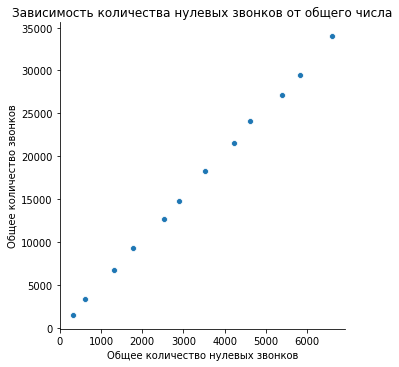

In [24]:
sns.relplot(x='count_0', y='count_all', data=calls_date)
plt.xlabel('Общее количество нулевых звонков')
plt.ylabel('Общее количество звонков')
plt.title('Зависимость количества нулевых звонков от общего числа')

На графике видно, что количество звонков с нулевой продолжительность прямопропорционально общему количеству звонков, что значит, что никаких подводных камней нет. Соответсвенно, можем заменить эти нулевые значения на единицу и округлить в большую сторону.

In [25]:
calls.loc[calls['duration'] == 0, 'duration'] = 1

In [26]:
calls['duration'] = calls['duration'].apply(np.ceil)

In [27]:
calls.head(20)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,1.0,1000,7
1,1000_1,2018-08-17,1.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12
5,1000_5,2018-11-02,1.0,1000,11
6,1000_6,2018-10-18,1.0,1000,10
7,1000_7,2018-08-22,19.0,1000,8
8,1000_8,2018-09-15,19.0,1000,9
9,1000_9,2018-08-15,1.0,1000,8


Теперь сделаем то же самое со значениями использованных мегобайтов.

Сразу добавим столбец со значением месяца.

In [28]:
internet['month'] = internet['session_date'].dt.month

In [29]:
internet_0 = internet.loc[internet['mb_used'] == 0]

In [30]:
internet_0.head()

,Unnamed: 0,id,mb_used,session_date,user_id,month
11,11,1000_11,0.0,2018-08-28,1000,8
38,38,1000_38,0.0,2018-11-27,1000,11
46,46,1000_46,0.0,2018-06-30,1000,6
67,67,1000_67,0.0,2018-06-16,1000,6
72,72,1000_72,0.0,2018-06-15,1000,6


In [31]:
internet_0_pv = internet_0.pivot_table(index='month', values = 'mb_used', aggfunc='count')

In [32]:
internet_0_pv.columns = ['count']

In [33]:
internet_0_pv

,count
month,
1,151
2,378
3,623
4,819
5,1199
6,1401
7,1760
8,2083
9,2314


In [34]:
internet_all = internet.pivot_table(index='month', values = 'mb_used', aggfunc='count')

In [35]:
internet_all.columns = ['count']

In [36]:
internet_all

,count
month,
1,1117
2,2641
3,4885
4,6511
5,9408
6,11057
7,13548
8,16092
9,17512


In [37]:
internet_0_pv['all'] =  internet_all['count']

In [38]:
internet_0_pv

,count,all
month,,
1,151,1117
2,378,2641
3,623,4885
4,819,6511
5,1199,9408
6,1401,11057
7,1760,13548
8,2083,16092
9,2314,17512


Постороим график

Text(0.5, 1, 'Зависимость количества нулевых Mb от общего числа')

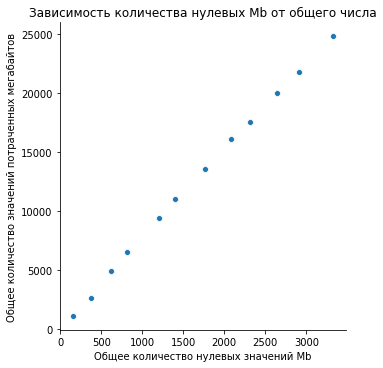

In [39]:
sns.relplot(x='count', y='all', data=internet_0_pv)
plt.xlabel('Общее количество нулевых значений Mb')
plt.ylabel('Общее количество значений потраченных мегабайтов')
plt.title('Зависимость количества нулевых Mb от общего числа')

Опять же, видна прямая заисимость между общим количеством и нулевыми значениями, а потому, можем с уверенность утверждать, что при замене нуля на единицу, существенных изменений не произойдет.

In [40]:
internet.loc[internet['mb_used'] == 0, 'duration'] = 1

In [41]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)

### Произведем подсчеты для каждого пользователя.

Количество сделанных звонков и израсходованных минут разговора по месяцам

Для начала объединим таблицы calls и users

In [42]:
calls_table = calls.merge(users, on='user_id', how='inner')

Создадим новую таблицу, которая составляет полное имя клиента и город, чтобы не появилось двойников

In [43]:
calls_table['full_name'] = calls_table['first_name']+' '+ calls_table['last_name']+' '+calls_table['city']

In [44]:
calls_table.head()

,id,call_date,duration,user_id,month,age,churn_date,city,first_name,last_name,reg_date,tariff,full_name
0,1000_0,2018-07-25,1.0,1000,7,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,Рафаил Верещагин Краснодар
1,1000_1,2018-08-17,1.0,1000,8,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,Рафаил Верещагин Краснодар
2,1000_2,2018-06-11,3.0,1000,6,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,Рафаил Верещагин Краснодар
3,1000_3,2018-09-21,14.0,1000,9,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,Рафаил Верещагин Краснодар
4,1000_4,2018-12-15,6.0,1000,12,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,Рафаил Верещагин Краснодар


создаем сводную таблицу, которая считала бы количество звонков и потраченных минут по месяцам.

In [45]:
calls_grouped = calls_table.pivot_table(values=['full_name', 'duration'], 
                       index=['user_id', 'month'], 
                       aggfunc={'full_name': 'count', 'duration': 'sum'})


In [46]:
calls_grouped.columns = ['duration', 'calls']

In [47]:
calls_grouped

duration  calls
user_id month                 
1000    5         164.0     22
        6         187.0     43
        7         346.0     47
        8         418.0     52
        9         478.0     58
...                 ...    ...
1498    10        258.0     41
1499    9          71.0      9
        10        473.0     68
        11        624.0     74
        12        505.0     69

[3174 rows x 2 columns]

Количество отправленных сообщений по месяцам

Точно также объединим таблицы messages и users

In [48]:
messages_table = messages.merge(users, on='user_id', how='inner')

In [49]:
messages_table.head()

,id,message_date,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000_0,2018-06-27,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000_1,2018-10-08,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000_2,2018-08-04,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000_3,2018-06-16,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000_4,2018-12-05,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Создадим столбец с полным именем

In [50]:
messages_table['full_name'] = messages_table['first_name']+' '+ messages_table['last_name']+' '+messages_table['city']

Добавим столбец с месяцем

In [51]:
messages_table['month'] = messages_table['message_date'].dt.month

Теперь создадим сводную таблицу

In [52]:
messages_grouped = messages_table.pivot_table(index=['user_id', 'month'], values='full_name', aggfunc={'full_name': 'count'})

In [53]:
messages_grouped.columns = ['messages']

In [54]:
messages_grouped

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
...                 ...
1498    10           42
1499    9            11
        10           48
        11           59
        12           66

[2717 rows x 1 columns]

объем израсходованного интернет-трафика по месяцам

Проделаем все то же самое и для этой задачи

In [55]:
internet_table = internet.merge(users, on='user_id', how='inner')

In [56]:
internet_table.head()

,Unnamed: 0,id,mb_used,session_date,user_id,month,duration,age,churn_date,city,first_name,last_name,reg_date,tariff
0,0,1000_0,113.0,2018-11-25,1000,11,NaN,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1,1000_1,1053.0,2018-09-07,1000,9,NaN,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,2,1000_2,1198.0,2018-06-25,1000,6,NaN,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,3,1000_3,551.0,2018-08-22,1000,8,NaN,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,4,1000_4,303.0,2018-09-24,1000,9,NaN,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [57]:
internet_table['full_name'] = internet_table['first_name']+' '+ internet_table['last_name']+' '+internet_table['city']

In [58]:
internet_grouped = internet_table.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc={'mb_used': 'sum'})

In [59]:
internet_grouped.columns = ['mb_used']

In [60]:
internet_grouped

mb_used
user_id month         
1000    5       2256.0
        6      23257.0
        7      14016.0
        8      14070.0
        9      14581.0
...                ...
1498    10     20604.0
1499    9       1848.0
        10     17809.0
        11     17984.0
        12     13077.0

[3203 rows x 1 columns]

Составим помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану)

Для начала, выведем все сводные таблицы и соединим в одну

In [61]:
grouped_data = calls_grouped.merge(internet_grouped, on=['user_id', 'month'], how='outer')

In [62]:
grouped_data_full = grouped_data.merge(messages_grouped, on=['user_id', 'month'], how='outer')

In [63]:
grouped_data_full.head(10)

duration  calls  mb_used  messages
user_id month                                    
1000    5         164.0   22.0   2256.0      22.0
        6         187.0   43.0  23257.0      60.0
        7         346.0   47.0  14016.0      75.0
        8         418.0   52.0  14070.0      81.0
        9         478.0   58.0  14581.0      57.0
        10        363.0   57.0  14717.0      73.0
        11        344.0   43.0  14768.0      58.0
        12        341.0   46.0   9827.0      70.0
1001    11        444.0   59.0  18452.0       NaN
        12        430.0   63.0  14053.0       NaN

In [64]:
### Код ревьювера ###

grouped_data_full.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5) to (1489, 12)
Data columns (total 4 columns):
duration    3174 non-null float64
calls       3174 non-null float64
mb_used     3203 non-null float64
messages    2717 non-null float64
dtypes: float64(4)
memory usage: 113.9 KB


На всякий случай все пропущенные значения заменим на 0

In [65]:
grouped_data_full.loc[grouped_data_full['duration'].isna(), 'duration'] = 0
grouped_data_full.loc[grouped_data_full['messages'].isna(), 'messages'] = 0
grouped_data_full.loc[grouped_data_full['mb_used'].isna(), 'mb_used'] = 0

Теперь перейдем к вычислениям. Но для начала, нужно каждому юзеру присвоить название тарифа.

In [66]:
for user in grouped_data_full.index:
    grouped_data_full.loc[user, 'tariff'] = users.loc[user[0]-1000, 'tariff']

Теперь напишем функцию, которая подсчитывает количество используемых ресурсов и выясняет, вышел ли клиент за лимит и потратил больше, или же он уложился в поставленные рамки. Заодно выведем данные тарифов.

In [67]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Отсюда будем брать данные для сравнения

In [68]:
def check_balance(row):
    duration = row['duration']
    messages = row['messages']
    calls = row['calls']
    mb_used = row['mb_used']
    tariff = row['tariff']
    
    
    
    if tariff == 'smart':
        extra_duration = duration - tariffs.loc[0, 'minutes_included']
        extra_gb = np.ceil(mb_used / 1024 - (tariffs.loc[0, 'mb_per_month_included']) / 1024)
        extra_messages = messages - tariffs.loc[0, 'messages_included']
        
        if extra_duration < 0: 
            extra_duration = 0
        if extra_gb < 0: 
            extra_gb = 0
        if extra_messages < 0: 
            extra_messages = 0
        
        return (tariffs.loc[0, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[0, 'rub_per_gb']) * extra_gb + 
                   tariffs.loc[0, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[0, 'rub_monthly_fee']
                  ) 
    else:
        extra_duration = duration - tariffs.loc[1, 'minutes_included']
        extra_gb = np.ceil(mb_used / 1024 - (tariffs.loc[1, 'mb_per_month_included']) / 1024)
        extra_messages = messages - tariffs.loc[1, 'messages_included']
        
        if extra_duration < 0: 
            extra_duration = 0
        if extra_gb < 0: 
            extra_gb = 0
        if extra_messages < 0: 
            extra_messages = 0
        
        return (tariffs.loc[1, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[1, 'rub_per_gb']) * extra_gb + 
                   tariffs.loc[1, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[1, 'rub_monthly_fee']
                  )

В этой функции можно как раз округлить значения потраченных гигабайт вверх.

In [69]:
grouped_data_full['balance'] = grouped_data_full.apply(check_balance, axis=1)

In [70]:
grouped_data_full.head(10)

duration  calls  mb_used  messages tariff  balance
user_id month                                                    
1000    5         164.0   22.0   2256.0      22.0  ultra   1950.0
        6         187.0   43.0  23257.0      60.0  ultra   1950.0
        7         346.0   47.0  14016.0      75.0  ultra   1950.0
        8         418.0   52.0  14070.0      81.0  ultra   1950.0
        9         478.0   58.0  14581.0      57.0  ultra   1950.0
        10        363.0   57.0  14717.0      73.0  ultra   1950.0
        11        344.0   43.0  14768.0      58.0  ultra   1950.0
        12        341.0   46.0   9827.0      70.0  ultra   1950.0
1001    11        444.0   59.0  18452.0       0.0  smart   1350.0
        12        430.0   63.0  14053.0       0.0  smart    550.0

## Этап 3. Анализ данных

Нужно ответить на вопрос: сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

In [71]:
median_values = grouped_data_full.pivot_table(index='tariff', values=['duration', 'messages', 'mb_used', 'balance', 'calls'], aggfunc='median')

In [72]:
median_values.head()

,balance,calls,duration,mb_used,messages
tariff,,,,,
smart,1075.0,60.0,435.0,16531.0,28.0
ultra,1950.0,75.0,532.0,19324.0,38.0


Из данной сводной таблицы мы можем понять, что пользователям тарифа Smart в целом хватает количества минут разговора, количества СМС, но не хватает интернет трафика - они его превышают в медианном значении на почти полтора гигабайта. В то же время для тарифа ультра предоставленных услуг хватает и даже остается очень много неиспользованных минут разговора, гигабайтов трафика и количества сообщений. Можно сделать вывод, что люди, пользующиеся этим тарифом, либо не сильно обременены платой ежемесячной и могут спокойно продолжать пользоваться тарифом дальше, либо им нудно перейти на другой тариф, более подходящий их запросам.

In [73]:
median_values_1 = grouped_data_full.pivot_table(index='user_id', values=['duration', 'messages', 'mb_used', 'balance'], aggfunc='median')

In [74]:
median_values_1.head()

,balance,duration,mb_used,messages
user_id,,,,
1000,1950.0,345.0,14325.5,65.0
1001,950.0,437.0,16252.5,0.0
1002,1150.0,221.0,17601.0,11.0
1003,1950.0,844.0,11368.0,83.0
1004,1950.0,136.5,17828.5,154.5


Снова придется добавить столбец с тарифами.

In [75]:
for user_id in users['user_id']:
    median_values_1.loc[user_id, 'tariff'] = users.loc[user_id-1000, 'tariff']

Теперь для каждого показателя найдем медиану, дисперсию и стандартное отклонение.

In [76]:
description = median_values_1.pivot_table(index='tariff', values=['duration', 'mb_used', 'messages'], 
                    aggfunc={'duration': [np.median, np.var, np.std], 
                             'mb_used': [np.median, np.var, np.std], 
                             'messages': [np.median, np.var, np.std]})

In [77]:
description

duration                            mb_used                             \
         median         std           var   median          std           var   
tariff                                                                          
smart     453.0  164.614327  27097.876586  16948.0  4179.542704  1.746858e+07   
ultra     550.5  311.491491  97026.949014  19750.5  8901.168701  7.923080e+07   

       messages                          
         median        std          var  
tariff                                   
smart      28.5  28.010653   784.596662  
ultra      47.5  49.236809  2424.263318

Можем заметить, что дисперсии для всех показателей для тарифа Ultra сильно выше.

А теперь построим графики.

In [78]:
median_values_1.dropna(subset=['duration'], inplace=True)

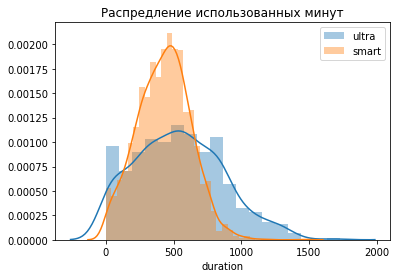

In [79]:
for tariff in ['ultra', 'smart']:
    sns.distplot(grouped_data_full.query('tariff == @tariff')['duration'], kde=True)
    plt.legend(['ultra', 'smart'])
    plt.title('Распредление использованных минут')
    
        

Что касается использованных минут общения, то пользователи тарифа Ultra распредлены более нормально по графику, а потому, можем предположить, что они обладают большей свободой и вариативностью в использовании этого ресурса. Напротив, пользователи тарифа Smart пытаюся использовать все ресурсы на полную, это видно по пику с 300 до 500, особенно в районе 500. Оба распределения похожи на нормальные, но при этом распредление тарифа Smart сильно скошено вправо.

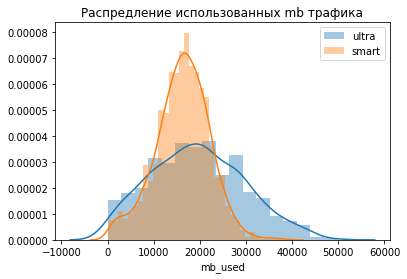

In [80]:
for tariff in ['ultra', 'smart']:
    sns.distplot(grouped_data_full.query('tariff == @tariff')['mb_used'], kde=True)
    plt.legend(['ultra', 'smart'])
    plt.title('Распредление использованных mb трафика')

Та же самая ситуация уже и с потраченными мегабайтами. Оба распрделения кажутся нормальными, даже без значительных выбросов.

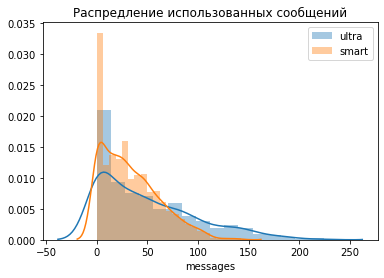

In [81]:
for tariff in ['ultra', 'smart']:
    sns.distplot(grouped_data_full.query('tariff == @tariff')['messages'], kde=True)
    plt.legend(['ultra', 'smart'])
    plt.title('Распредление использованных сообщений')

А вот здесь интересно, большая часть пользователей тарифа смарт отправляет мало сообщений, даже несмотря на то, что у них их всего 50 включенных. Пользователи же тарифа Ultra в целом тоже отправляют мало сообщений, намного меньше заложенных в тариф 1000. Оба распредления достаточно похожи на нормальные, однако в тарифе Ultra мы видим больше выбросов. При этом, обе гистограммы скошены вправо.

### Intermediate output.

Based on the information obtained earlier during the analysis, we can conclude that the Ultra tariff meets all the requests of its users and even exceeds them, mostly, of course. This is especially noticeable in the distribution of minutes spent. In the same place, we also see that a very large part of the Smart tariff customers can not meet the minutes required by the tariff and are forced to overpay. The same picture is with the spent Internet traffic, many users of the Smart tariff do not fit into their 15 GB limit. With messages, too, a similar picture, it is very difficult to exceed 300 messages, but it is quite easy to cross the line in 50 messages, but still not so many people do it now few people seem to use it.

## Этап 4. Проверка гипотез.

H0 - средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт».

H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

alpha = 0.05

Нулевую гипотезу нужно всегда формировать так, чтобы в ней присутсвовал знак равенства.

На основании ранее проделанного анализа и разницы в дсиперсиях нужно будет указать значением параметра equal_var = False, используем ttest_ind, потому что проверяем гипотезу о равенстве средних двух генеральных совукупностей.

In [82]:
ultra = grouped_data_full.query('tariff == "ultra"')['balance']
smart = grouped_data_full.query('tariff == "smart"')['balance']
alpha = 0.05
results = st.ttest_ind(
    smart,
    ultra,
    equal_var = False)
print('p-значение:', results.pvalue )
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 2.2071398635388917e-234
Отвергаем нулевую гипотезу


In [83]:
grouped_data_full.pivot_table(index='tariff', values='balance', aggfunc='median')

,balance
tariff,
smart,1075.0
ultra,1950.0


Согласно полученным данным о средних двух выборок, делаем вывод, что Мегалайн намного больше зарабатывает с клиентов тарифа Smart, потому что они платят почти в два раза больше положенной суммы, так как не укладываются в лимиты интренет-трафика. Согласно полученным данным из анализа выше вывод следующий:средняя выручка с пользователей тарифов «Ультра» и «Смарт» различаются.

-------------------------------------------------------------------------------

H0 - средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

H1 - средняя выручка пользователей из Москвы отличается от средней выручке пользователей из других регионов.

alpha = 0.05

Исходя из заданного вопроса в задании формируем нулевую гпотезу, которая описывала бы ситуация равенства, на основании нулевой гипотезы выдвигаем противоположную ей. Также будем использовать ttest_ind

Сначала надо добавить столбец с городами.

In [84]:
for user in grouped_data_full.index:
    grouped_data_full.loc[user, 'city'] = users.loc[user[0]-1000, 'city']

In [85]:
grouped_data_full.head()

duration  calls  mb_used  messages tariff  balance       city
user_id month                                                               
1000    5         164.0   22.0   2256.0      22.0  ultra   1950.0  Краснодар
        6         187.0   43.0  23257.0      60.0  ultra   1950.0  Краснодар
        7         346.0   47.0  14016.0      75.0  ultra   1950.0  Краснодар
        8         418.0   52.0  14070.0      81.0  ultra   1950.0  Краснодар
        9         478.0   58.0  14581.0      57.0  ultra   1950.0  Краснодар

In [86]:
moscow = grouped_data_full.query('city == "Москва"')['balance']
regions = grouped_data_full.query('city != "Москва"')['balance']
alpha = 0.05
results = st.ttest_ind(
    moscow, 
    regions, 
    equal_var=False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5612228736965572
Не получилось отвергнуть нулевую гипотезу


In [87]:
def region(city):
    if city == 'Москва':
        return 'Москва'
    else:
        return 'Не Москва'

In [88]:
grouped_data_full['region'] = grouped_data_full['city'].apply(region)

In [89]:
grouped_data_full.pivot_table(index='region', values='balance', aggfunc='median')

,balance
region,
Москва,1776.0
Не Москва,1631.0


Нулевую гипотезу отвергнуть не получилось, а это значит, что средняя выручка пользователей из Москвы примерно равна средней выручке пользователей из других регионов

## Step 5. General output.

As a result of the study, it was found that Megaline's revenue from the Smart tariff is higher than from the Ultra tariff. If the users of the latter do not exceed the specified limits and fit into the required amount, then in the Smart tariff people do not have enough Internet traffic, and on average they go beyond the limits by 1.5 GB, which forces them to pay an additional 300 rubles per month.

Another hypothesis about the difference in revenue in different regions was not confirmed, most likely this is due to the fact that in all regions the pricing policy is the same, and the needs of people in the consumption of content and communication with others depend more on personal characteristics than on regional affiliation.